In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import blimpy as bl
import pandas as pd
from astropy import units as u

import sys, os, glob, errno
import csv
import json
import h5py
import time
from astropy.stats import sigma_clip


from scipy.signal import butter, lfilter, filtfilt
import scipy.signal

sys.path.insert(0, "/home/bryanb/setigen/")
import setigen as stg

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

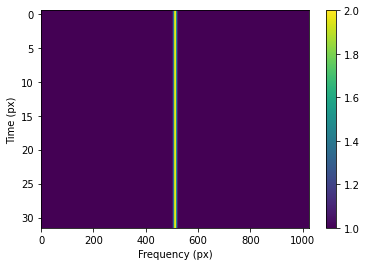

1.0


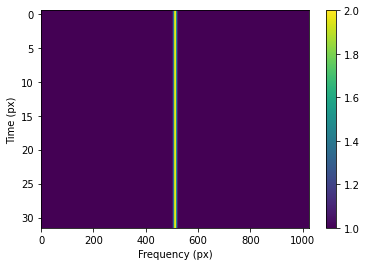

1.0


In [13]:
data = np.ones((32, 1024))
frame = stg.Frame.from_data(df=1, dt=1, fch1=0, data=data)
frame.add_signal(stg.constant_path(f_start=frame.get_frequency(index=512),
                                   drift_rate=0),
                 stg.constant_t_profile(level=1),
                 stg.gaussian_f_profile(width=10),
                 stg.constant_bp_profile(level=1))
frame.render()
plt.show()
print(data.max())

frame = stg.Frame.from_data(df=1, dt=1, fch1=0, data=data)
frame.add_signal(stg.constant_path(f_start=frame.get_frequency(index=512),
                                   drift_rate=0),
                 stg.constant_t_profile(level=1),
                 stg.gaussian_f_profile(width=10),
                 stg.constant_bp_profile(level=1))
frame.render()
plt.show()
print(data.max())

1.0


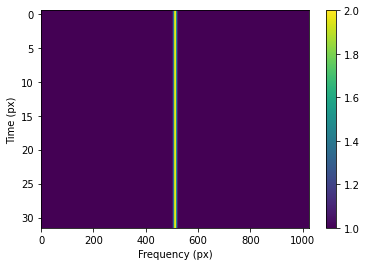

In [14]:
total = np.ones((16, 32, 1024))

data = total[5, :, :]
frame = stg.Frame.from_data(df=1, dt=1, fch1=0, data=data)
frame.add_signal(stg.constant_path(f_start=frame.get_frequency(index=512),
                                   drift_rate=0),
                 stg.constant_t_profile(level=1),
                 stg.gaussian_f_profile(width=10),
                 stg.constant_bp_profile(level=1))
frame.render()
print(data.max())

In [15]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

try:
    import cupy as xp
except ImportError:
    import numpy as xp
import numpy as np

from astropy import units as u
import blimpy as bl


def get_numpy(v):
    try:
        return xp.asnumpy(v)
    except AttributeError:
        return v
    
def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

delays = np.array([0, 1e-6, 2e-6]) * sample_rate
maa = stg.voltage.MultiAntennaArray(num_antennas=3,
                                    sample_rate=sample_rate,
                                    fch1=6*u.GHz,
                                    ascending=False,
                                    num_pols=2,
                                    delays=delays)

for stream in maa.bg_streams:
    stream.add_noise(v_mean=0,
                     v_std=1)
    stream.add_constant_signal(f_start=5998.9e6, 
                               drift_rate=0*u.Hz/u.s, 
                               level=0.0025)
    
for stream in maa.antennas[0].streams:
    stream.add_noise(0, 1)

for stream in maa.antennas[1].streams:
    stream.add_noise(0, 2)
    stream.add_constant_signal(f_start=5000.3e6, 
                               drift_rate=0*u.Hz/u.s, 
                               level=0.002)

for stream in maa.antennas[2].streams:
    stream.add_noise(0, 3)
    stream.add_constant_signal(f_start=5000.7e6, 
                               drift_rate=0*u.Hz/u.s, 
                               level=0.004)

In [19]:
vars(maa)

{'rng': <cupy.random._generator.RandomState at 0x7f545951cf70>,
 'delays': array([   0, 3000, 6000]),
 'max_delay': 6000,
 'num_antennas': 3,
 'sample_rate': 3000000000.0,
 'dt': 3.333333333333333e-10,
 'fch1': 6000000000.0,
 'ascending': False,
 'num_pols': 2,
 't_start': 0,
 'start_obs': True,
 'antennas': [<setigen.voltage.antenna.Antenna at 0x7f545951cd60>,
 'bg_x': <setigen.voltage.data_stream.BackgroundDataStream at 0x7f545951cdc0>,
 'bg_streams': [<setigen.voltage.data_stream.BackgroundDataStream at 0x7f545951cdc0>,
 'bg_y': <setigen.voltage.data_stream.BackgroundDataStream at 0x7f5459544280>}

In [26]:
vars(maa.antennas[2].x)

{'rng': <cupy.random._generator.RandomState at 0x7f54595440a0>,
 'sample_rate': 3000000000.0,
 'dt': 3.333333333333333e-10,
 'fch1': 6000000000.0,
 'ascending': False,
 'noise_std': array(3.),
 'bg_noise_std': array(1.),
 't_start': 0,
 'start_obs': True,
 'noise_sources': [<function setigen.voltage.data_stream.DataStream.add_noise.<locals>.<lambda>(ts)>],
 'signal_sources': [<function setigen.voltage.data_stream.DataStream.add_constant_signal.<locals>.signal_func(ts)>]}

In [28]:
for antenna in maa.antennas:
    for stream in antenna.streams:
        print(stream.get_total_noise_std())

1.4142135623730951
1.4142135623730951
2.23606797749979
2.23606797749979
3.1622776601683795
3.1622776601683795


In [39]:
a = np.random.normal(0, 1, 1000) + np.random.normal(1000, 2, 1000)
np.std(a)**2

5.0385825312601265

In [41]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

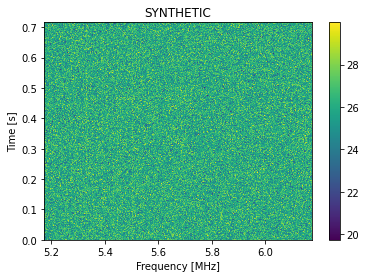

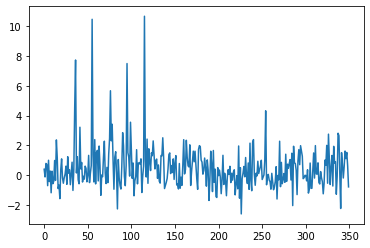

In [55]:
fn = '/datax/scratch/bbrzycki/data/raw_files/test_snr_actual.rawspec.0000.fil'

fftlength = 1024
f = chan_bw / fftlength * int(fftlength*(2+0.3-0.5)) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.1,
                  f_stop=f+0.9)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

def snr_integrate_t(frame):
    m, s = frame.get_noise_stats()
    spectrum = np.mean(frame.data, axis=0)
    return (spectrum - m) / (s / frame.shape[0]**0.5)

spec = snr_integrate_t(frame)
plt.plot(spec)

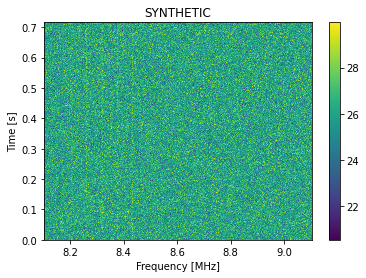

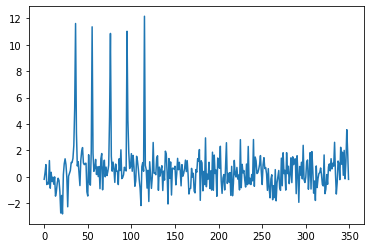

In [56]:
f = chan_bw / fftlength * int(fftlength*(3+0.3-0.5)) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.1,
                  f_stop=f+0.9)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

def snr_integrate_t(frame):
    m, s = frame.get_noise_stats()
    spectrum = np.mean(frame.data, axis=0)
    return (spectrum - m) / (s / frame.shape[0]**0.5)

spec = snr_integrate_t(frame)
plt.plot(spec)

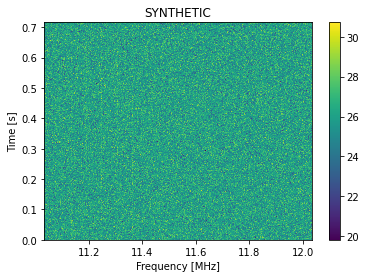

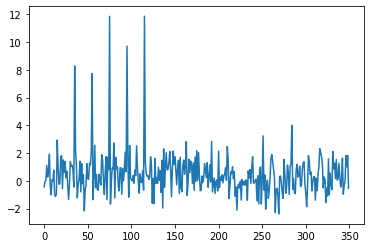

In [57]:
f = chan_bw / fftlength * int(fftlength*(4+0.3-0.5)) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.1,
                  f_stop=f+0.9)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

def snr_integrate_t(frame):
    m, s = frame.get_noise_stats()
    spectrum = np.mean(frame.data, axis=0)
    return (spectrum - m) / (s / frame.shape[0]**0.5)

spec = snr_integrate_t(frame)
plt.plot(spec)

In [58]:
!rawspec -f 1048576 -t 51 /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight

working stem: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0000.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0001.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0002.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0003.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0004.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0005.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0006.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0007.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0008.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0009.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0010.raw
opening file:

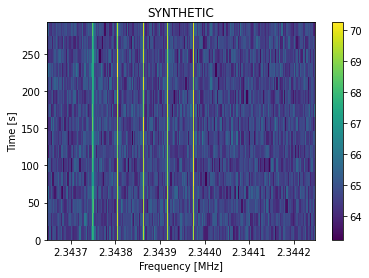

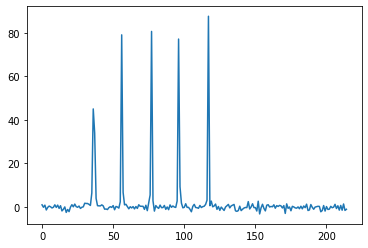

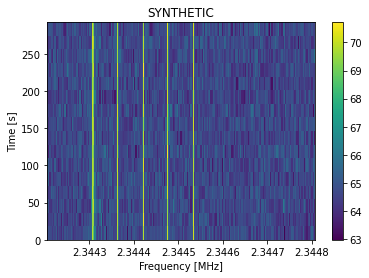

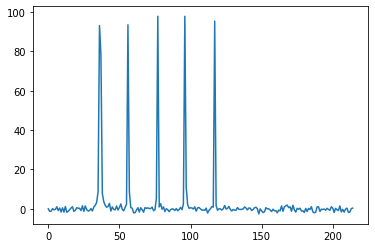

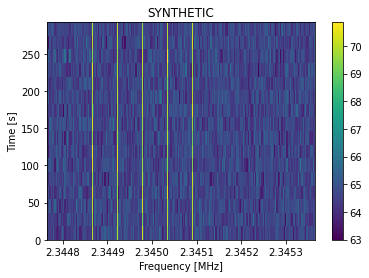

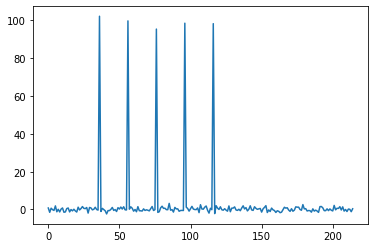

In [59]:
fn = '/datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.rawspec.0000.fil'
fftlength = 1048576
f = chan_bw / fftlength * (int(fftlength*(1+0.3-0.5))) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.0005)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)
plt.show()

f = chan_bw / fftlength * (int(fftlength*(1+0.3-0.5))+200) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.0005)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)
plt.show()

f = chan_bw / fftlength * (int(fftlength*(1+0.3-0.5))+400) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.0005)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)
plt.show()

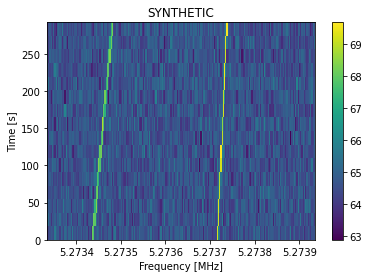

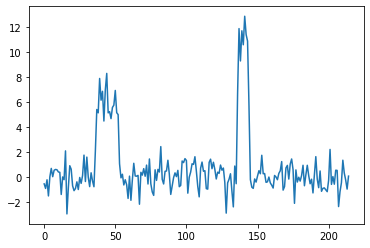

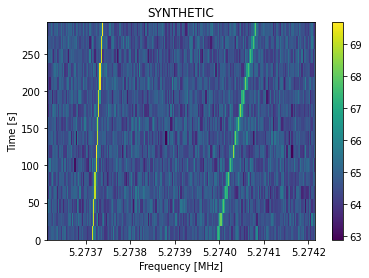

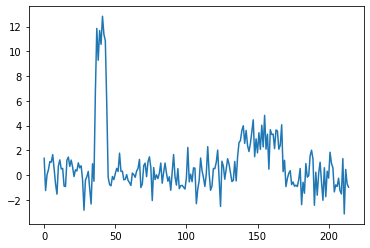

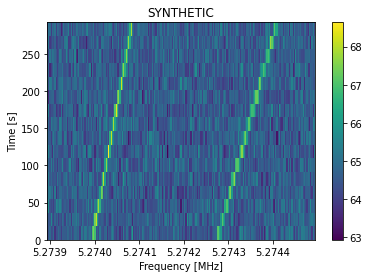

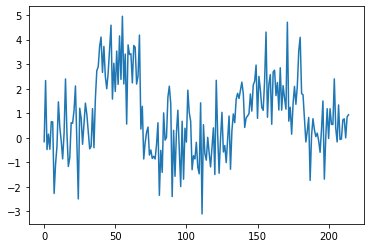

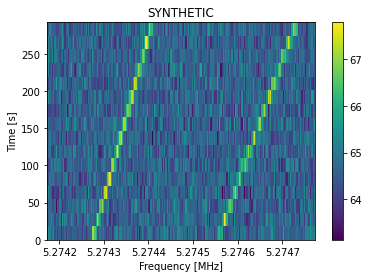

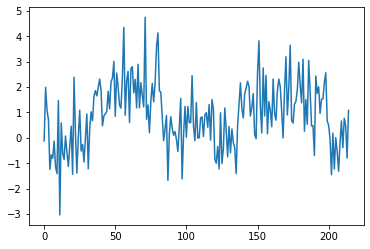

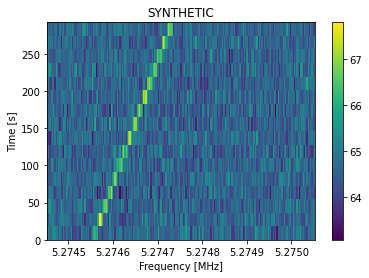

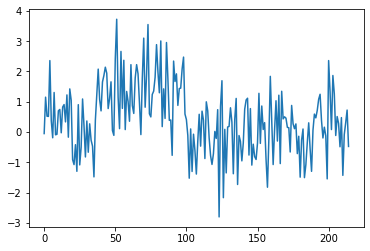

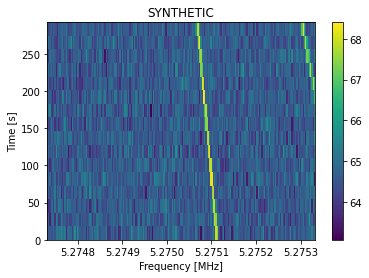

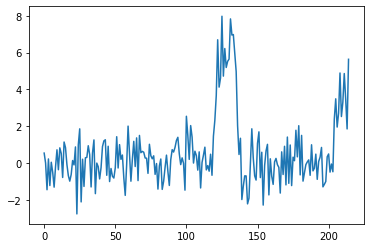

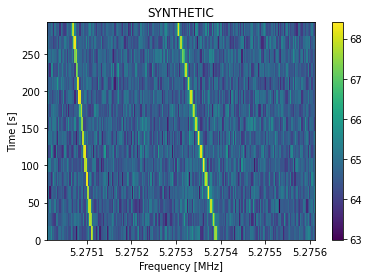

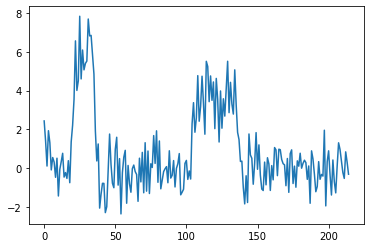

In [60]:
for i in range(7):

    f = chan_bw / fftlength * (int(fftlength*(2+0.3-0.5))+100*i) / 1e6
    wf = bl.Waterfall(fn,
                      f_start=f-0.0001,
                      f_stop=f+0.0005)
    wf.plot_waterfall()
    plt.show()

    frame = stg.Frame(wf)

    spec = snr_integrate_t(frame)
    plt.plot(spec)
    plt.show()

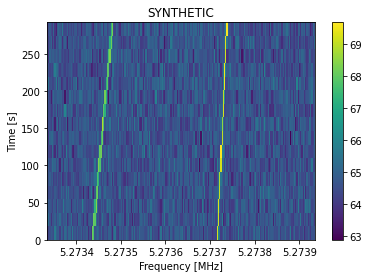

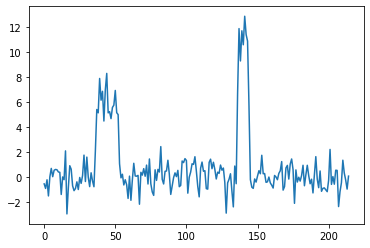

In [61]:
f = chan_bw / fftlength * (int(fftlength*(2+0.3-0.5))+0) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.0005)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)
plt.show()

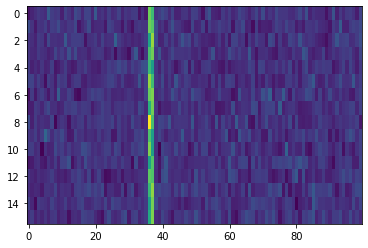

In [64]:
idx_a = np.expand_dims(np.arange(frame.data.shape[0]), 1).repeat(100, axis=1)
idx_b = np.expand_dims(np.arange(frame.data.shape[0]), 1) + np.expand_dims(np.arange(100), 1).T
temp_data = frame.data[idx_a, idx_b]
plt.imshow(temp_data, aspect='auto', interpolation='none')
plt.show()

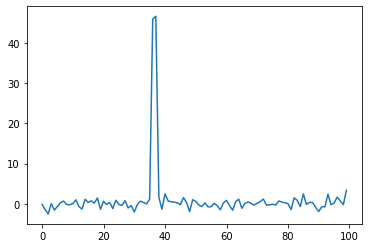

In [65]:
def snr_integrate_data(frame, data):
    m, s = frame.get_noise_stats()
    spectrum = np.mean(data, axis=0)
    return (spectrum - m) / (s / frame.shape[0]**0.5)

spec = snr_integrate_data(frame, temp_data)
plt.plot(spec)
plt.show()

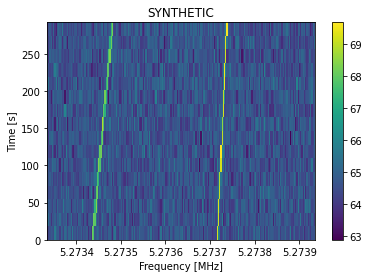

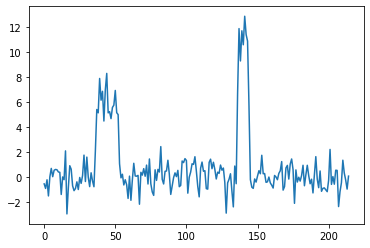

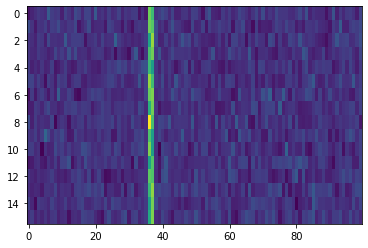

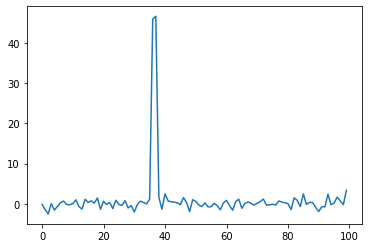

46.601547

In [73]:
f = chan_bw / fftlength * (int(fftlength*(2+0.3-0.5))+0) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.0005)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)
plt.show()

idx_a = np.expand_dims(np.arange(frame.data.shape[0]), 1).repeat(100, axis=1)
idx_b = np.expand_dims(np.arange(frame.data.shape[0])*1, 1) + np.expand_dims(np.arange(100), 1).T
temp_data = frame.data[idx_a, idx_b]
plt.imshow(temp_data, aspect='auto', interpolation='none')
plt.show()

spec = snr_integrate_data(frame, temp_data)
plt.plot(spec)
plt.show()

np.max(spec)

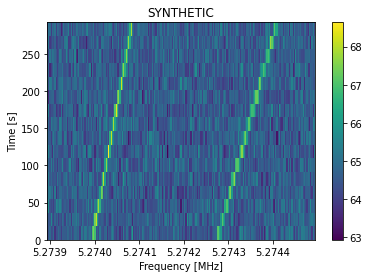

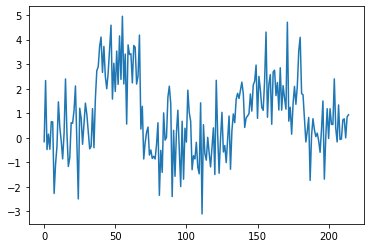

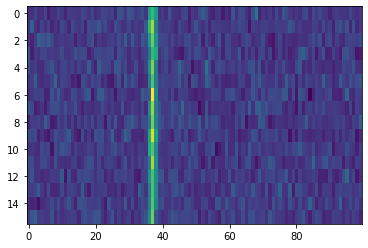

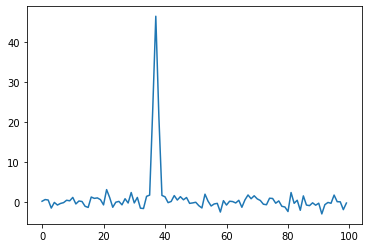

46.37038

In [72]:
f = chan_bw / fftlength * (int(fftlength*(2+0.3-0.5))+200) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.0005)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)
plt.show()

idx_a = np.expand_dims(np.arange(frame.data.shape[0]), 1).repeat(100, axis=1)
idx_b = np.expand_dims(np.arange(frame.data.shape[0])*2, 1) + np.expand_dims(np.arange(100), 1).T
temp_data = frame.data[idx_a, idx_b]
plt.imshow(temp_data, aspect='auto', interpolation='none')
plt.show()

spec = snr_integrate_data(frame, temp_data)
plt.plot(spec)
plt.show()

np.max(spec)

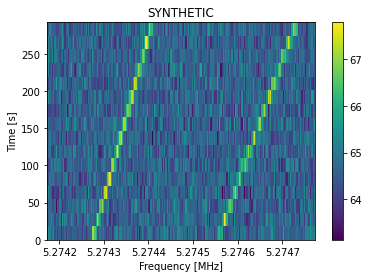

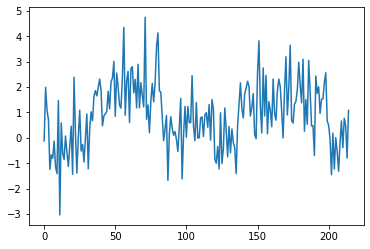

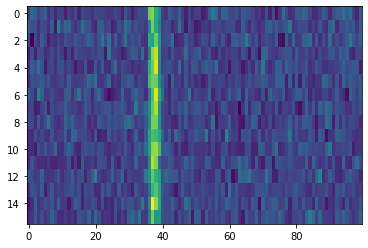

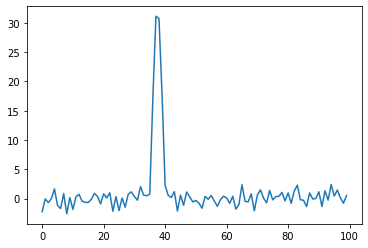

31.117989

In [74]:
f = chan_bw / fftlength * (int(fftlength*(2+0.3-0.5))+300) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.0005)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)
plt.show()

idx_a = np.expand_dims(np.arange(frame.data.shape[0]), 1).repeat(100, axis=1)
idx_b = np.expand_dims(np.arange(frame.data.shape[0])*3, 1) + np.expand_dims(np.arange(100), 1).T
temp_data = frame.data[idx_a, idx_b]
plt.imshow(temp_data, aspect='auto', interpolation='none')
plt.show()

spec = snr_integrate_data(frame, temp_data)
plt.plot(spec)
plt.show()

np.max(spec)

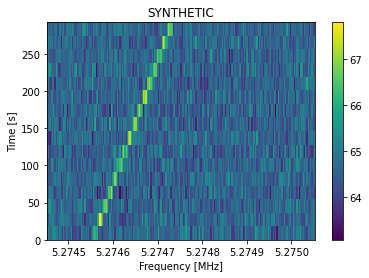

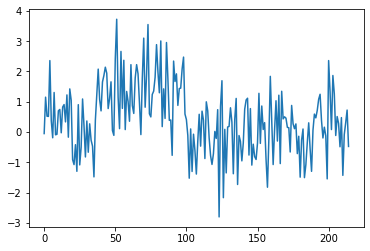

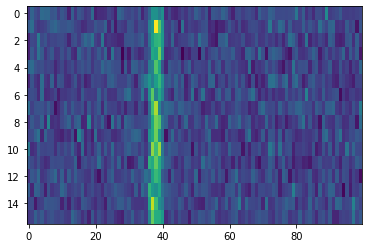

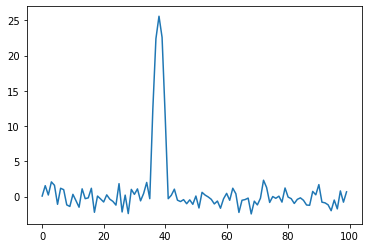

25.579803

In [75]:
f = chan_bw / fftlength * (int(fftlength*(2+0.3-0.5))+400) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.0005)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)
plt.show()

idx_a = np.expand_dims(np.arange(frame.data.shape[0]), 1).repeat(100, axis=1)
idx_b = np.expand_dims(np.arange(frame.data.shape[0])*4, 1) + np.expand_dims(np.arange(100), 1).T
temp_data = frame.data[idx_a, idx_b]
plt.imshow(temp_data, aspect='auto', interpolation='none')
plt.show()

spec = snr_integrate_data(frame, temp_data)
plt.plot(spec)
plt.show()

np.max(spec)

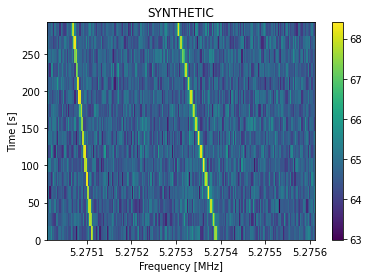

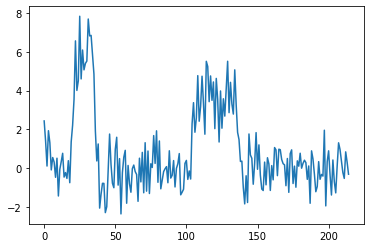

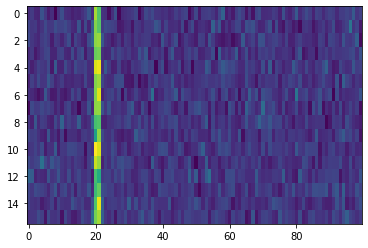

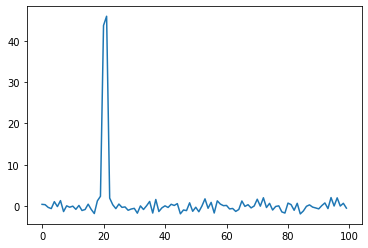

45.985863

In [77]:
f = chan_bw / fftlength * (int(fftlength*(2+0.3-0.5))+600) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.0005)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)
plt.show()

idx_a = np.expand_dims(np.arange(frame.data.shape[0]), 1).repeat(100, axis=1)
idx_b = np.expand_dims(np.arange(frame.data.shape[0])[::-1], 1) + np.expand_dims(np.arange(100), 1).T
temp_data = frame.data[idx_a, idx_b]
plt.imshow(temp_data, aspect='auto', interpolation='none')
plt.show()

spec = snr_integrate_data(frame, temp_data)
plt.plot(spec)
plt.show()

np.max(spec)

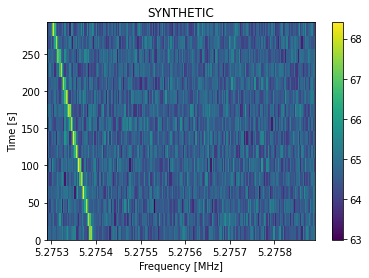

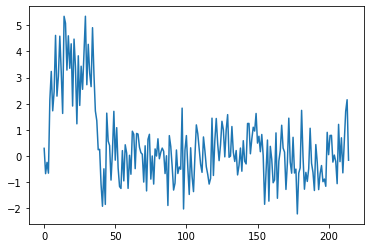

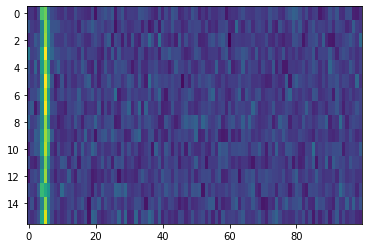

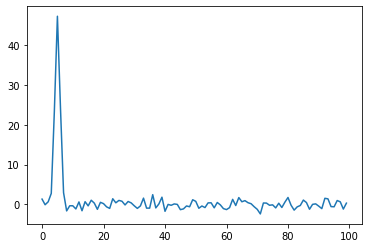

47.23864

In [78]:
f = chan_bw / fftlength * (int(fftlength*(2+0.3-0.5))+700) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.0005)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)
plt.show()

idx_a = np.expand_dims(np.arange(frame.data.shape[0]), 1).repeat(100, axis=1)
idx_b = np.expand_dims(np.arange(frame.data.shape[0])[::-1]*2, 1) + np.expand_dims(np.arange(100), 1).T
temp_data = frame.data[idx_a, idx_b]
plt.imshow(temp_data, aspect='auto', interpolation='none')
plt.show()

spec = snr_integrate_data(frame, temp_data)
plt.plot(spec)
plt.show()

np.max(spec)

In [79]:
!rawspec -f 1048576 -t 51 /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight

working stem: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0000.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0001.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0002.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0003.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0004.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0005.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0006.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0007.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0008.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0009.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0010.raw
opening file:

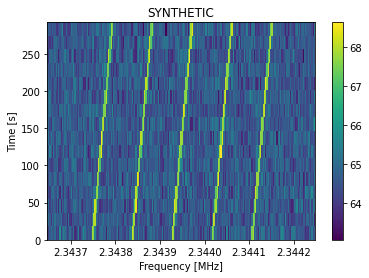

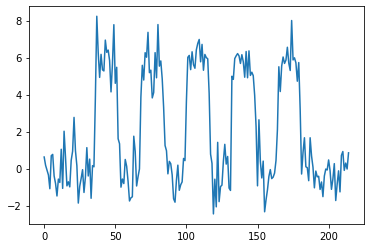

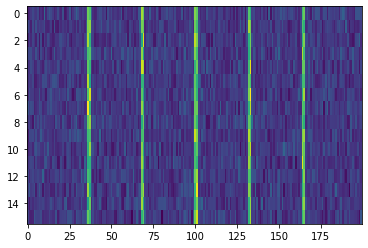

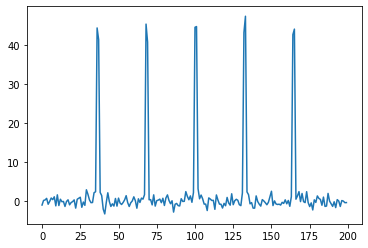

47.44053

In [87]:
f = chan_bw / fftlength * (int(fftlength*(1+0.3-0.5))+0) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.0005)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)
plt.show()

idx_a = np.expand_dims(np.arange(frame.data.shape[0]), 1).repeat(200, axis=1)
idx_b = np.expand_dims(np.arange(frame.data.shape[0]), 1) + np.expand_dims(np.arange(200), 1).T
temp_data = frame.data[idx_a, idx_b]
plt.imshow(temp_data, aspect='auto', interpolation='none')
plt.show()

spec = snr_integrate_data(frame, temp_data)
plt.plot(spec)
plt.show()

np.max(spec)

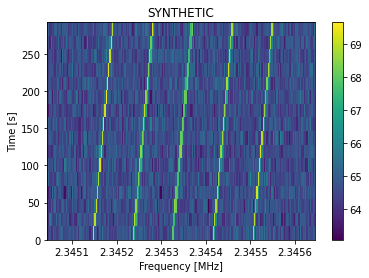

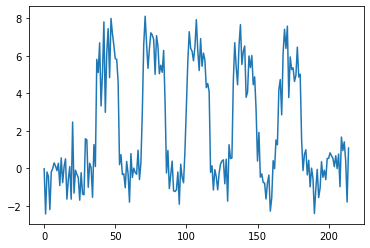

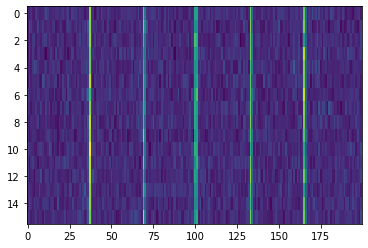

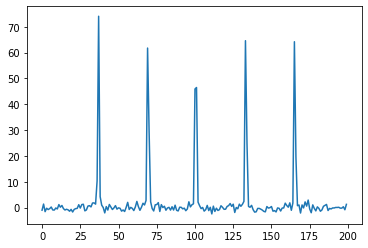

74.09337

In [88]:
f = chan_bw / fftlength * (int(fftlength*(1+0.3-0.5))+500) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.0005)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)
plt.show()

idx_a = np.expand_dims(np.arange(frame.data.shape[0]), 1).repeat(200, axis=1)
idx_b = np.expand_dims(np.arange(frame.data.shape[0]), 1) + np.expand_dims(np.arange(200), 1).T
temp_data = frame.data[idx_a, idx_b]
plt.imshow(temp_data, aspect='auto', interpolation='none')
plt.show()

spec = snr_integrate_data(frame, temp_data)
plt.plot(spec)
plt.show()

np.max(spec)

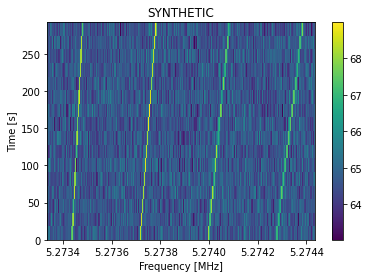

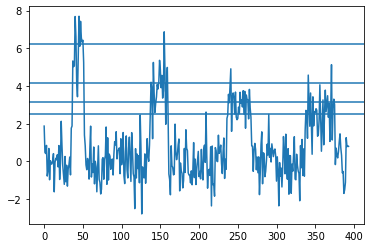

In [92]:
f = chan_bw / fftlength * (int(fftlength*(2+0.3-0.5))+0) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.001)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)

for b in [1, 1.5, 2, 2.5]:
    y = 100 / 16 / b
    plt.axhline(y)

plt.show()



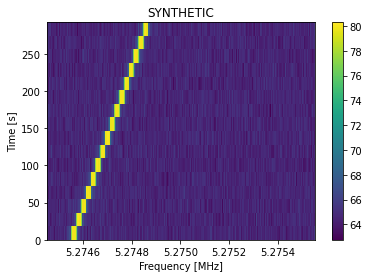

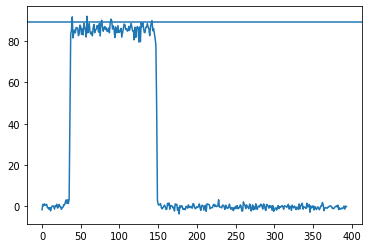

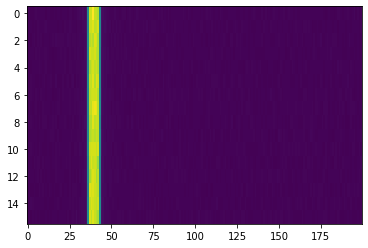

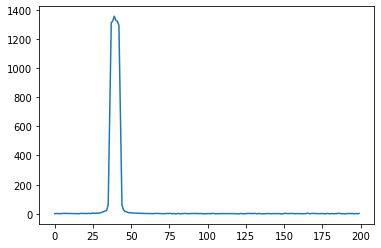

1358.4061

In [98]:
f = chan_bw / fftlength * (int(fftlength*(2+0.3-0.5))+400) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.001)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)

for b in [7]:
    y = 10000 / 16 / b
    plt.axhline(y)

plt.show()

idx_a = np.expand_dims(np.arange(frame.data.shape[0]), 1).repeat(200, axis=1)
idx_b = np.expand_dims(np.arange(frame.data.shape[0])*7, 1) + np.expand_dims(np.arange(200), 1).T
temp_data = frame.data[idx_a, idx_b]
plt.imshow(temp_data, aspect='auto', interpolation='none')
plt.show()

spec = snr_integrate_data(frame, temp_data)
plt.plot(spec)
plt.show()

np.max(spec)

In [104]:
!rawspec -f 1048576 -t 51 /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight

working stem: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0000.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0001.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0002.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0003.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0004.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0005.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0006.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0007.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0008.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0009.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0010.raw
opening file:

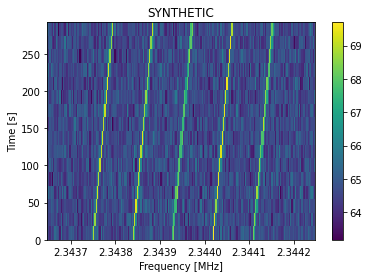

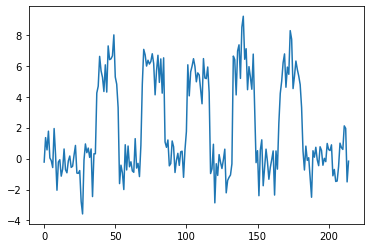

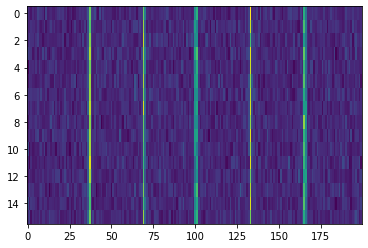

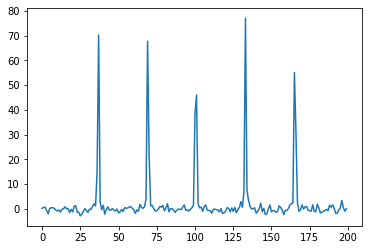

76.99295

In [105]:
f = chan_bw / fftlength * (int(fftlength*(1+0.3-0.5))+0) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.0005)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)
plt.show()

idx_a = np.expand_dims(np.arange(frame.data.shape[0]), 1).repeat(200, axis=1)
idx_b = np.expand_dims(np.arange(frame.data.shape[0]), 1) + np.expand_dims(np.arange(200), 1).T
temp_data = frame.data[idx_a, idx_b]
plt.imshow(temp_data, aspect='auto', interpolation='none')
plt.show()

spec = snr_integrate_data(frame, temp_data)
plt.plot(spec)
plt.show()

np.max(spec)

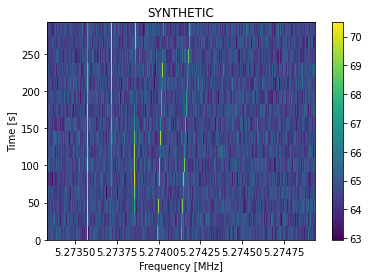

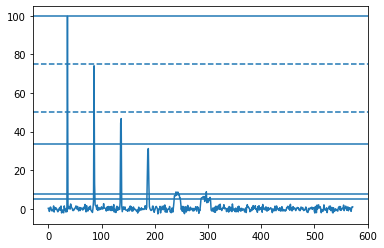

In [109]:
f = chan_bw / fftlength * (int(fftlength*(2+0.3-0.5))+0) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.0015)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)

for b in [1/16, 3/16, 0.8, 1.2]:
    y = 100 / 16 / b
    plt.axhline(y)
    
plt.axhline(50, ls='--')
plt.axhline(75, ls='--')
    
plt.show()



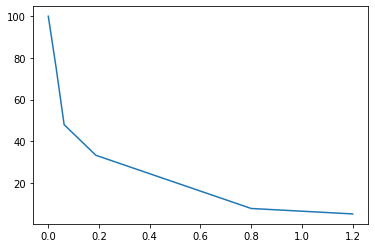

In [135]:
x = np.array([0, 1/32, 1/16, 3/16, 0.8, 1.2])
y = np.array([100, 75, 48, 100/16/(3/16), 100/16/0.8, 100/16/1.2])
plt.plot(x, y)

In [117]:
1/16

0.0625

In [137]:
np.argmax(spec)

36

In [138]:
spec[36]

99.713356

In [140]:
spec[36+50],spec[36+100]

(74.06043, 44.34929)

In [141]:
!rawspec -f 1048576 -t 51 /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight

working stem: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0000.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0001.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0002.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0003.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0004.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0005.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0006.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0007.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0008.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0009.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0010.raw
opening file:

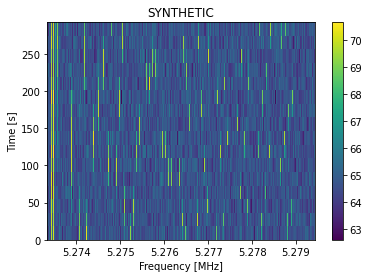

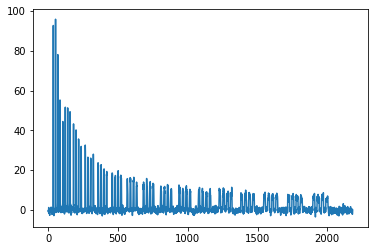

In [148]:
f = chan_bw / fftlength * (int(fftlength*(2+0.3-0.5))+0) / 1e6
wf = bl.Waterfall(fn,
                  f_start=f-0.0001,
                  f_stop=f+0.006)
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spec = snr_integrate_t(frame)
plt.plot(spec)




In [151]:
np.argsort(spec)[::-1]

array([  52,   36,   68, ..., 2083,  387, 1915])

In [159]:
x = np.arange(64)/64
y = np.zeros(64)
for i in range(64):
    width = i//4+1
    idx = 36 + i*(width+15)
    data_range = spec[idx:idx+width]
    m = data_range.mean()
    
    y[i] = m

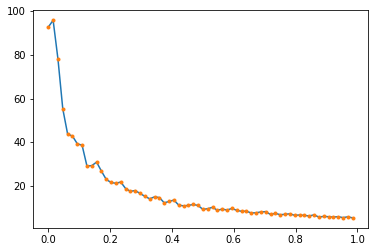

In [166]:
plt.plot(x, y, '-')
plt.plot(x, y, '.')
plt.show()

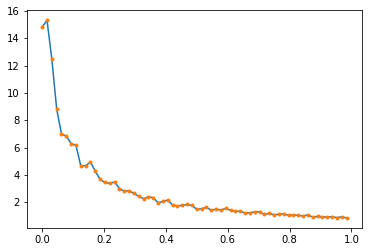

In [167]:
plt.plot(x, y*16/100, '-')
plt.plot(x, y*16/100, '.')
plt.show()

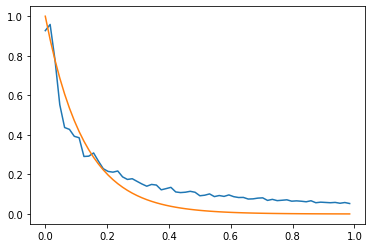

In [178]:
plt.plot(x, y/100, '-')
plt.plot(x, np.exp(-x*8))
plt.show()